# About Formula 1

Formula 1 is the premier class of international autoracing and one of the fastest motorsports in the world with the cars regularly reaching speeds of over 200 mph (322 km/h) during races. Each Formula 1 season is a battle for two separate titles based on cummulative points scored during the season. One title for the drivers - the World Drivers' Championship - and another title for the constructors - the World Constructors' Championship.

The Formula One World Championship, previously called the World Drivers' Championship, is now in its 72nd season, and thanks to recent additions of multiple television deals around the world Formula 1 is possibly more popular now more than ever. 

Being a fairly new spectator of the sport, having only been watching the last 3 or 4 seasons, I wanted to put together some general questions a novice like myself might ask to learn more about the sport. These should be fairly straight-forward and easy to answer with the use of data science techniques.

After answering the straight-forward questions I will then create a predictive model to help answer the question, "What effect does being on pole (starting the race in first place) have on a driver's final position at the race's end?"

# About the dataset

The data being used were resourced from the kaggle.com dataset **Formula 1 World Championship (1950 - 2021)**. The data were orginally from five csv files which include information for race results, circuits, drivers, and constructors.

# Questions

In this presentation I am trying to answer a few simple questions using the data provided.
1. How many drivers have participated in Formula 1?
2. What countries have produced the most drivers?
3. Has a race ever been won by an American?
4. Who are the most successful constructors (teams)?
5. Who are the most successful drivers?
6. What effect does being on pole (starting the race in first place) have on a driver's final position at the race's end?
7. How likely is a driver to win at Monaco if he starts on the pole?

In [1]:
# import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas_profiling

In [2]:
# import the data from the csv files

results = pd.read_csv('results.csv') # results are through raceId 1052 - Bahrain GP 28-Mar-2021
driver = pd.read_csv('drivers.csv')
constructor_standings = pd.read_csv('constructor_standings.csv')
constructors = pd.read_csv('constructors.csv')
constructor_results = pd.read_csv('constructor_results.csv')

In [3]:
# merge results and drivers on driverId

drivers = results.merge(driver, how='inner', on='driverId')

In [4]:
# drop unecessary columns

drivers.drop(columns=['grid','laps','statusId','driverRef','number','code','dob','url'], inplace=True)

In [5]:
# merge constructor dataframes on constructorId then constructorId, raceId, and points

teams = constructor_results.merge(constructor_standings.merge(constructors, how='inner', on='constructorId'), how='inner', on=['constructorId','raceId','points'])

In [6]:
teams.head()

,constructorResultsId,raceId,constructorId,points,status,constructorStandingsId,position,positionText,wins,constructorRef,name,nationality,url
0,1,18,1,14.0,\N,1,1,1,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,18,2,8.0,\N,2,3,3,0,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,18,3,9.0,\N,3,2,2,0,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,18,4,5.0,\N,4,4,4,0,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,18,5,2.0,\N,5,5,5,0,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


In [7]:
# drop unecessary columns

teams.drop(columns=['raceId','status','constructorStandingsId','position','positionText','constructorRef','nationality','url'], inplace=True)

In [8]:
# rename columns

drivers.columns = ['Result ID','Race ID','Driver ID','Constructor ID','Final Position','Driver Points','forename','surname','Nationality']

teams.columns = ['Constructor Results ID','Constructor ID','Constructor Points','Constructor Wins', 'Constructor Name']

In [9]:
# concatenate driver forename and surname

drivers['Name'] = drivers['forename']+' '+drivers['surname']

# drop forename and surname

drivers.drop(columns=['forename','surname'], inplace=True)

In [10]:
drivers.head()

,Result ID,Race ID,Driver ID,Constructor ID,Final Position,Driver Points,Nationality,Name
0,7554,1,18,23,1,10.0,British,Jenson Button
1,7574,2,18,23,1,5.0,British,Jenson Button
2,7596,3,18,23,3,6.0,British,Jenson Button
3,7614,4,18,23,1,10.0,British,Jenson Button
4,7634,5,18,23,1,10.0,British,Jenson Button


In [11]:
teams.head()

,Constructor Results ID,Constructor ID,Constructor Points,Constructor Wins,Constructor Name
0,1,1,14.0,1,McLaren
1,2,2,8.0,0,BMW Sauber
2,3,3,9.0,0,Williams
3,4,4,5.0,0,Renault
4,5,5,2.0,0,Toro Rosso


## How many drivers have participated in F1?

In [12]:
# find the number of unique values for driverId

print('There have been '+str(len(drivers['Driver ID'].unique()))+' drivers participate in Formula 1 since 1950.')

There have been 853 drivers participate in Formula 1 since 1950.


## What countries have produced the most drivers?

Now I want to know what countries have produced the most drivers.

In [13]:
# list the unique values that appear in nationality

print(drivers['Nationality'].unique())
len(drivers['Nationality'].unique())

['British' 'Brazilian' 'Italian' 'German' 'Spanish' 'Swiss' 'French'
 'Australian' 'Polish' 'Finnish' 'Japanese' 'Austrian' 'American' 'Dutch'
 'Colombian' 'Portuguese' 'Canadian' 'Indian' 'Hungarian' 'Irish' 'Danish'
 'Malaysian' 'Argentine' 'Czech' 'Belgian' 'Monegasque' 'Swedish'
 'Russian' 'Venezuelan' 'New Zealander' 'Chilean' 'Mexican'
 'South African' 'Liechtensteiner' 'Rhodesian' 'American-Italian'
 'Uruguayan' 'Argentine-Italian' 'Thai' 'East German' 'Indonesian']


41

I see that while there are 41 unique values two of them - 'American-Italian' and 'Argentine-Italian' - contain multiple countries of nationality.

I'll explore these two drivers a little more.

In [14]:
# find out which drivers are listed as 'American-Italian' and 'Argentine-Italian'

print(drivers[(drivers['Nationality']=='American-Italian') | (drivers['Nationality']=='Argentine-Italian')]['Name'].unique())

['Alfonso Thiele' 'Alessandro de Tomaso']


A quick google search will show that both drivers participated in auto racing under the flags of each nation. I'll leave their nationalities as is.

In [15]:
# find the number of drivers under each nationality

nationality_count = driver['nationality'].value_counts().to_frame('Counts').reset_index()
nationality_count.rename(columns={'index':'Nationality'}, inplace=True)

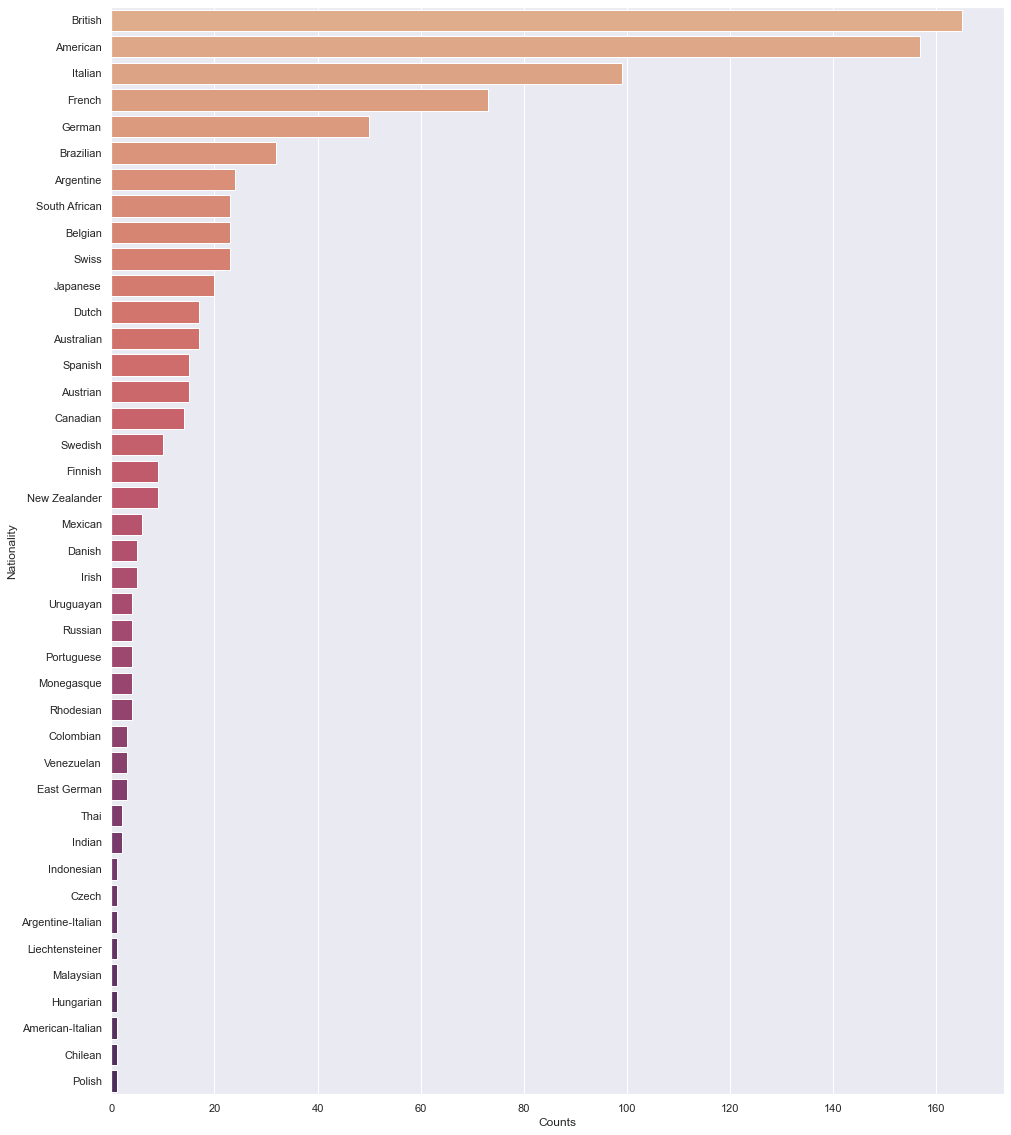

,Nationality,Counts
0,British,165
1,American,157
2,Italian,99
3,French,73
4,German,50


In [16]:
plt.figure(figsize=(16,20))
sns.barplot(data=nationality_count, y='Nationality', x='Counts', palette='flare')
plt.show()

nationality_count.head(5)

With the popularity of F1 in Europe it seems typical to have 4 of the top 5 driver producing countries located in this region. What is very surprising to find is that the United States has produced the second most drivers with 157, trailing only Britain which has produced 165.

## Has an American ever won an F1 race?

With Americans taking second place in total number of drivers I'm not curious to find out if an American has ever won a race.

In [17]:
# create a dataframe that includes American drivers that have finished 1st

US_winners = drivers[(drivers['Final Position']==1) & (drivers['Nationality']=='American')]

In [18]:
# print the number of American winners and the number of races they've won

print('There have been ' + str(len(US_winners['Name'].unique())) + ' American drivers that have won an F1 race.')
print('')
print('Together they have won ' + str(US_winners['Final Position'].count()) + ' races')

There have been 15 American drivers that have won an F1 race.

Together they have won 33 races


## Who are the most successful constructors (teams)?

Find the top 5 constructors with the most season wins and race wins and how many average points do they receive per race win.

In [19]:
season_wins = teams.groupby(['Constructor Name']).sum()['Constructor Wins'].sort_values(ascending=False).reset_index()
season_wins.columns = ['Constructor Name','Season Wins']

In [20]:
season_wins.head()

,Constructor Name,Season Wins
0,Ferrari,15
1,McLaren,14
2,Williams,7
3,Mercedes,6
4,Renault,6


In [21]:
# find the total number of points for each constructor

total_con_pts = drivers.groupby('Constructor ID').agg({'Driver Points': 'sum'})['Driver Points'].sort_values(ascending=False).reset_index()

# find the number of races the constructor has won

con_wins = drivers[drivers['Final Position']==1].groupby(['Constructor ID']).sum()['Final Position'].sort_values(ascending=False).reset_index()

# find the number of races each constructor participated in

con_appearances = drivers['Constructor ID'].value_counts().reset_index()

# rename the columns

total_con_pts.columns = ['Constructor ID', 'Constructor Points']
con_wins.columns = ['Constructor ID','Race Wins']
con_appearances.columns = ['Constructor ID','Race Appearances']

In [22]:
total_con_pts = total_con_pts.merge(constructors, left_on='Constructor ID', right_on='constructorId')
total_con_pts.drop(columns=['constructorId','constructorRef','nationality','url'], inplace=True)
total_con_pts.columns = ['Constructor ID', 'Constructor Points','Constructor Name']

In [24]:
# merge all constructor data

con_alldata = total_con_pts.merge(con_wins.merge(con_appearances, how='inner', on='Constructor ID'), how='inner', on='Constructor ID')

In [25]:
con_alldata.head()

,Constructor ID,Constructor Points,Constructor Name,Race Wins,Race Appearances
0,6,9304.77,Ferrari,239,2261
1,131,5865.14,Mercedes,116,474
2,1,5741.50,McLaren,178,1745
3,9,5071.50,Red Bull,64,610
4,3,3567.00,Williams,114,1499


In [25]:
# add a points per win column

con_alldata['Points per Win'] = round(con_alldata['Constructor Points']/con_alldata['Race Wins'],1)

In [26]:
# add a winning percentage column

con_alldata['Winning %'] = round(con_alldata['Race Wins']/con_alldata['Race Appearances']*100,2)

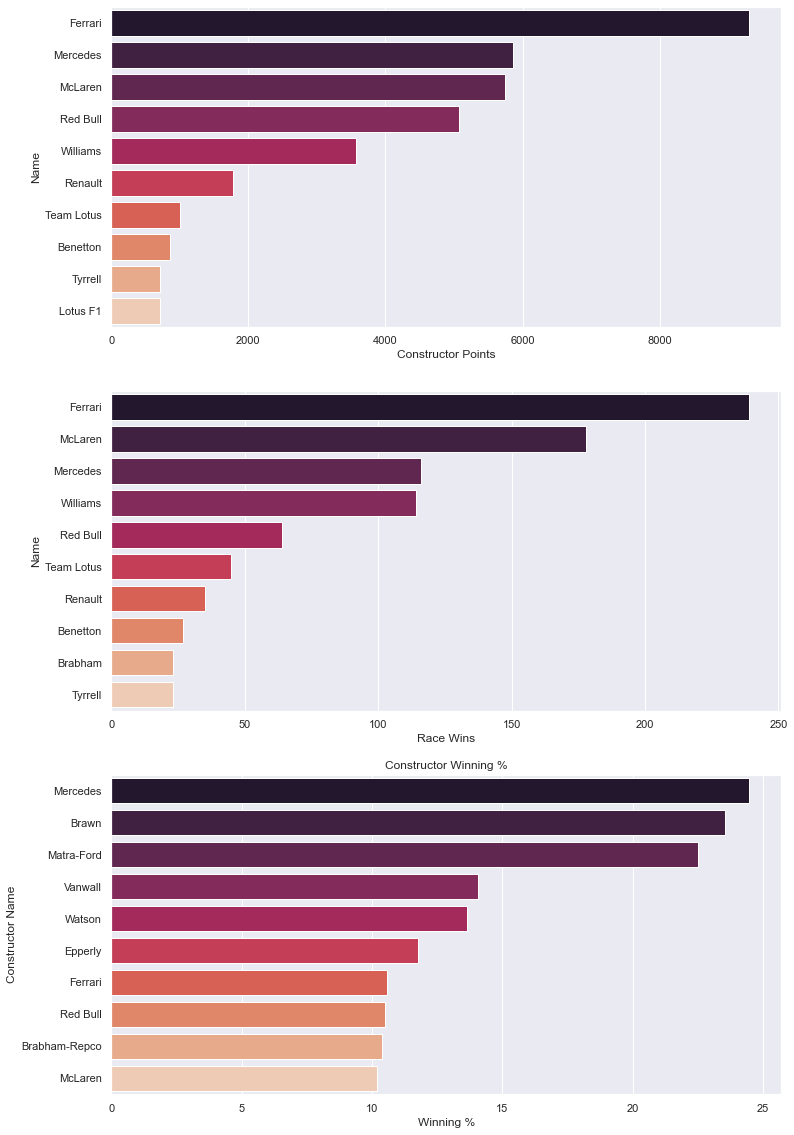

In [27]:
fig, axs = plt.subplots(nrows=3, figsize=(12,20))

sns.barplot(data=con_alldata.head(10), y='Name', x='Constructor Points', palette="rocket", ax=axs[0])
plt.title('Most Constructor Points (all time)')
plt.xlabel('Points')
plt.ylabel('Constructor Name')

df1 = con_alldata.groupby(['Constructor ID','Name']).sum()['Race Wins'].sort_values(ascending=False).to_frame('Race Wins').reset_index()
sns.barplot(data=df1.head(10), y='Name', x='Race Wins', palette="rocket", ax=axs[1])
plt.title('Most Constructor Race Wins')
plt.xlabel('Race Wins')
plt.ylabel('Constructor Name')

df2 = con_alldata.groupby(['Constructor ID','Name']).sum()['Winning %'].sort_values(ascending=False).reset_index()
sns.barplot(data=df2.head(10), y='Name', x='Winning %', palette="rocket", ax=axs[2])
plt.title('Constructor Winning %')
plt.xlabel('Winning %')
plt.ylabel('Constructor Name')

plt.show()

In [28]:
con_alldata.sort_values(by='Winning %', ascending=False).head(10)

,Constructor ID,Constructor Points,Name,Race Wins,Race Appearances,Points per Win,Winning %
1,131,5865.14,Mercedes,116,474,50.6,24.47
23,23,172.00,Brawn,8,34,21.5,23.53
28,196,130.00,Matra-Ford,9,40,14.4,22.50
30,118,108.00,Vanwall,10,71,10.8,14.08
41,107,36.00,Watson,3,22,12.0,13.64
40,108,44.00,Epperly,2,17,22.0,11.76
0,6,9304.77,Ferrari,239,2261,38.9,10.57
3,9,5071.50,Red Bull,64,610,79.2,10.49
22,191,175.00,Brabham-Repco,8,77,21.9,10.39
2,1,5741.50,McLaren,178,1745,32.3,10.20


## Which drivers have the most race wins all time?

In [29]:
winners = drivers[drivers['Final Position']==1].groupby(['Name']).sum()['Final Position'].sort_values(ascending=False).reset_index()

In [30]:
driver_appearances = drivers['Name'].value_counts().to_frame().reset_index()

In [31]:
winners.columns=['Name', 'Number of Wins']
driver_appearances.columns=['Name','Races']

In [32]:
winners2 = winners.merge(driver_appearances, how='inner', on='Name')
winners2['Winning %'] = round(winners2['Number of Wins']/winners2['Races']*100,2)

In [33]:
winners2.head()

,Name,Number of Wins,Races,Winning %
0,Lewis Hamilton,96,267,35.96
1,Michael Schumacher,91,308,29.55
2,Sebastian Vettel,53,259,20.46
3,Alain Prost,51,202,25.25
4,Ayrton Senna,41,162,25.31


## What effect does being on pole (starting the race in first position) have on a driver's final position at the race's end?

## How likely is a driver to win at Monaco if he starts on the pole?

The Monaco Grand Prix is one of the oldest and most prestigious races in Formula 1. The Circuit de Monaco weaves its way through the streets of Monte Carlo and La Condamine through narrow streets and tight corners. Because of this race enthusiasts claim there is very little passing on the circuit and Monaco is won on Saturdays by qualifying in pole position.

Is this true? Is Monaco "won" on Saturdays?